In [1095]:
import itertools
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# column descriptions from https://www.retrosheet.org/gamelogs/glfields.txt
offensive_stats = ['AB', 'H', '2B', '3B', 'HR', 'RBI', 'SAC', 'SAC_FLY', 'HBP', 'BB', 'IBB', 'K', 'SB', 'CS', 'GDP', 'CI', 'LOB']
pitching_stats = ['pitchers_used', 'indv_earned_runs', 'team_earned_runs', 'wild_pitches', 'balks']
defensive_stats = ['putouts', 'assists', 'errors', 'passed_balls', 'double_plays', 'triple_plays']
roles = ['home_plate_ump', '1B_ump', '2B_ump', '3B_ump', 'LF_ump', 'RF_ump', 'away_manager', 'home_manager', 'winning_pitcher',
         'losing_pitcher', 'saving_pitcher', 'winning_rbi_batter', 'away_starting_pitcher', 'home_starting_pitcher']
columns = [
    'date',
    'series_game_num',
    'dow',
    'away',
    'away_league',
    'away_game_num',
    'home',
    'home_league',
    'home_game_num',
    'score_away',
    'score_home',
    'count_outs',
    'day_or_night',
    'makeup_info',
    'forfeit_info',
    'protest_info',
    'park_id',
    'attendance',
    'length_minutes',
    'away_line_score',
    'home_line_score',
    *['away_' + offensive_stat for offensive_stat in offensive_stats],
    *['away_' + pitching_stat for pitching_stat in pitching_stats],
    *['away_' + defensive_stat for defensive_stat in defensive_stats],
    *['home_' + offensive_stat for offensive_stat in offensive_stats],
    *['home_' + pitching_stat for pitching_stat in pitching_stats],
    *['home_' + defensive_stat for defensive_stat in defensive_stats],
    *list(itertools.chain.from_iterable([[role + '_id', role + '_name'] for role in roles])),
    *list(itertools.chain.from_iterable([[f'away_lineup{i}_id', f'away_lineup{i}_name', f'away_lineup{i}_pos'] for i in range(1, 10)])),
    *list(itertools.chain.from_iterable([[f'home_lineup{i}_id', f'home_lineup{i}_name', f'home_lineup{i}_pos'] for i in range(1, 10)])),
    'misc',
    'acquisition_info'
]

def file_to_df(fn):
    df = pd.read_csv(fn, header=None, names=columns)
    df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')
    df['year'] = df['date'].dt.year
    df['home_won'] = df['score_home'] > df['score_away']
    return df

def opposite_side(side):
    return 'home' if side == 'away' else 'away'

def opposite_outcome(win):
    if win == 0:
        return 1
    return 0
    
dfs = []
for fn in os.listdir('data'):
    if 'GL' in fn:
        year_df = file_to_df(f'data/{fn}')
        dfs.append(year_df)
    
game_logs = pd.concat(dfs).sort_values(['date', 'home_game_num', 'away_game_num'])
game_logs['home'] = game_logs['home'].replace('FLO', 'MIA') # The Florida Marlins became the Miami Marlins in 2011
game_logs['away'] = game_logs['away'].replace('FLO', 'MIA')

<AxesSubplot:title={'center':'The accuracy of the odds takes about a third of the season to stabilize'}, xlabel='month'>

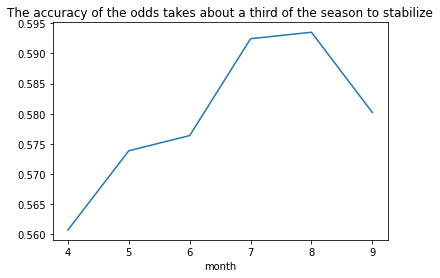

In [1096]:
odds_dfs = []
for fn in os.listdir('data'):
    if 'odds' in fn:
        odds_df = pd.read_csv(f'data/{fn}', encoding_errors='ignore')
        odds_df = odds_df[~odds_df['Date'].isna()]
        year = fn.replace('.csv', '').split(' ')[2]
        odds_df['date'] = pd.to_datetime(year + odds_df['Date'].astype(int).astype(str), format='%Y%m%d')
        odds_dfs.append(odds_df)
        
odds = pd.concat(odds_dfs)
        
TEAMS_MAPPING = {
    'CHC': 'CHN',
    'BRS': 'MIL',
    'LAD': 'LAN',
    'SFG': 'SFN',
    'CUB': 'CHN',
    'CWS': 'CHA',
    'KAN': 'KCA',
    'LAA': 'ANA',
    'LOS': 'LAN',
    'NYM': 'NYN',
    'NYY': 'NYA',
    'SDG': 'SDN',
    'SFO': 'SFN',
    'STL': 'SLN',
    'TAM': 'TBA'
}
odds['team'] = odds['Team'].apply(lambda team: TEAMS_MAPPING.get(team, team))
odds = odds.groupby(['team', 'date']).first().reset_index() # best way to handle double headers for now

home_odds = odds.loc[odds['VH'] == 'H', ['date', 'team', 'Close', 'Open']].rename(columns={
    'team': 'home', 'Close': 'home_odds_close', 'Open': 'home_open_odds'})
tmp = pd.merge(game_logs, home_odds, on=['date', 'home'])
away_odds = odds.loc[odds['VH'] == 'V', ['date', 'team', 'Close', 'Open']].rename(columns={
    'team': 'away', 'Close': 'away_odds_close', 'Open': 'away_open_odds'})
df = pd.merge(tmp, away_odds, on=['date', 'away'])
implied_odds = lambda line: 100 / (line + 100) if line > 0 else -line / (-line + 100)
df['home_odds_close'] = df['home_odds_close'].replace('NL', np.nan).astype(float).apply(implied_odds)
df['away_odds_close'] = df['away_odds_close'].replace('NL', np.nan).astype(float).apply(implied_odds)
df['home_open_odds'] = df['home_open_odds'].replace('NL', np.nan).astype(float).apply(implied_odds)
df['away_open_odds'] = df['away_open_odds'].replace('NL', np.nan).astype(float).apply(implied_odds)

df['home_favorite'] = (df['home_odds_close'] > df['away_odds_close']).astype(int)
df['odds_close'] = df['home_odds_close'] / (df['home_odds_close'] + df['away_odds_close'])
df['odds_open'] = df['home_open_odds'] / (df['home_open_odds'] + df['away_open_odds'])

df['month'] = df['date'].dt.month
df[(df['month'] > 3) & (df['month'] < 10)].groupby('month').apply(
    lambda group: accuracy_score(group['home_won'], group['home_favorite'])
).plot(title="The accuracy of the odds takes about a third of the season to stabilize")

In [1043]:
def build_features(year_to_test, proper_shift=1):
    one_year = df.loc[df['year'] == year_to_test]

    side_games_dfs = []
    for side in ['home', 'away']:
        side_games = one_year.copy()
        side_games['won'] = one_year['home_won'] if side == 'home' else ~one_year['home_won']
        side_games['team'] = one_year[side]
        side_games['game_num'] = one_year[f'{side}_game_num'] + proper_shift # join on game after, to avoid lookahead bias
        side_games['score_for'] = one_year[f'score_{side}']
        side_games['score_against'] = one_year[f'score_{opposite_side(side)}']
        for stat in offensive_stats + defensive_stats + pitching_stats:
            side_games[stat] = one_year[f'{side}_{stat}']
            side_games[f'opponent_{stat}'] = one_year[f'{opposite_side(side)}_{stat}']
        side_games_dfs.append(side_games)

    team_games = pd.concat(side_games_dfs).sort_values(['team', 'game_num'])
    
    stacked_cumsum = {col: team_games.pivot(columns='team', values=col, index='game_num').cumsum()
                      for col in list(team_games.select_dtypes(include=[np.number, bool]).columns)}
    stacked_10 = {col: team_games.pivot(columns='team', values=col, index='game_num').rolling(10).sum()
                  for col in list(team_games.select_dtypes(include=[np.number, bool]).columns)}
    
    stacked_features = {}
    for suffix, stacked, game_num in [
        ('', stacked_cumsum, stacked_cumsum['won'].index.values - proper_shift),
        ('_10', stacked_10, 10)
    ]:

        stacked_features[f'win_pct{suffix}'] = stacked['won'].divide(game_num, axis='rows')
        stacked_features[f'era{suffix}'] = stacked['indv_earned_runs'].divide(game_num, axis='rows')
        stacked_features[f'whip{suffix}'] = (stacked['opponent_H'] + stacked['opponent_BB']).divide(game_num * 9, axis='rows')
        stacked_features[f'fip{suffix}'] = (stacked['opponent_HR'] * 13 + stacked['opponent_BB'] * 3 - stacked['opponent_K'] * 2).divide(
            game_num * 9, axis='rows')
        stacked_features[f'obp{suffix}'] = ((stacked['H'] + stacked['BB'] + stacked['HBP']) / (
            stacked['AB'] + stacked['BB'] + stacked['HBP'] + stacked['SAC_FLY']))
        singles = stacked['H'] - stacked['HR'] - stacked['3B'] - stacked['2B']
        stacked_features[f'slg{suffix}'] = (singles + 2 * stacked['2B'] + 3 * stacked['3B'] + 4 * stacked['HR']) / stacked['AB']
        stacked_features[f'ops{suffix}'] = stacked_features[f'obp{suffix}'] + stacked_features[f'slg{suffix}']
        stacked_features[f'err{suffix}'] = stacked['errors'].divide(game_num, axis='rows')
        stacked_features[f'pythag{suffix}'] = (stacked['score_for']**1.83 / (stacked['score_for']**1.83 + stacked['score_against']**1.83))
        
    team_stats = pd.concat([stacked_feature.unstack().rename(stacked_feature_name)
                            for stacked_feature_name, stacked_feature in stacked_features.items()],
                           axis='columns').reset_index()

    tmp = pd.merge(
        one_year[['date', 'year', 'home', 'away', 'home_game_num', 'away_game_num', 'odds_close', 'odds_open',
                  'home_odds_close', 'away_odds_close', 'home_won', 'home_favorite']],
        team_stats.rename(columns={col: 'home' if col == 'team' else f'home_{col}' for col in team_stats.columns}),
        on=['home', 'home_game_num']
    )
    games = pd.merge(
        tmp,
        team_stats.rename(columns={col: 'away' if col == 'team' else f'away_{col}' for col in team_stats.columns}),
        on=['away', 'away_game_num']
    ).sort_values(['date', 'home_game_num'])

    games['log5'] = ((games['home_win_pct'] - (games['home_win_pct'] * games['away_win_pct'])) / (
        games['home_win_pct'] + games['away_win_pct'] - (2 * games['home_win_pct'] * games['away_win_pct'])
    ).replace(0, 1)).astype(float) # the denominator is only zero when the numerator is zero, so add .replace(0, 1) to avoid ZeroDivisionError
    games['log5_10'] = ((games['home_win_pct_10'] - (games['home_win_pct_10'] * games['away_win_pct_10'])) / (
        games['home_win_pct_10'] + games['away_win_pct_10'] - (2 * games['home_win_pct_10'] * games['away_win_pct_10'])
        
    ).replace(0, 1)).astype(float)
    for feature_name in stacked_features.keys():
        games[f'{feature_name}_diff'] = games[f'home_{feature_name}'] - games[f'away_{feature_name}']
    games['odds_shift'] = games['odds_open'] - games['odds_close']
    return games

games = pd.concat([build_features(year) for year in range(df['year'].min(), df['year'].max() + 1)], ignore_index=True).dropna()
games['home_won'] = games['home_won'].astype(int)

In [1313]:
# Tuning Logistic Regression regularization parameter

from hyperopt import hp, fmin
from hyperopt import rand, tpe
from hyperopt import Trials

def accuracy_tune(model):
    scores = []
    for year in range(2017, games['year'].max() + 1):
        i_train = (games['year'] < year) & (games['home_game_num'] > 53)
        model.fit(games.loc[i_train, features_list], games.loc[i_train, 'home_won'])
        i_test = (games['year'] == year) & (games['home_game_num'] > 20)
        test = games.loc[i_test, ['date', 'home_won', 'home_favorite', 'home_odds_close', 'away_odds_close', 'odds_close']]
        scores.append(-accuracy_score(test['home_won'], model.predict(games.loc[i_test, features_list])))
    return np.mean(scores)

def objective(param):
    model = LogisticRegression(max_iter=1000, C=param)
    return accuracy_tune(model)

tpe_trials = Trials()
C_hat = fmin(fn=objective, space=hp.uniform('C_hat', 0, 1), algo=tpe.suggest, trials=tpe_trials, max_evals=100)['C_hat']

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/trial, best loss: -0.5979429271178502]


In [1294]:
max_depth_hat = 1
min_accuracy_tune = 0
for d in range(2, 7):
    model = XGBClassifier(verbosity=0, use_label_encoder=False, max_depth=d)
    trial = accuracy_tune(model)
    if trial < min_accuracy_tune:
        min_accuracy_tune = trial
        max_depth_hat = d

In [1317]:
def objective(param, kwarg='eta'):
    kwargs = {'tree_method': 'exact', 'max_depth': max_depth_hat, kwarg: param}
    model = XGBClassifier(verbosity=0, use_label_encoder=False, **kwargs)
    return accuracy_tune(model)

tpe_trials = Trials()
eta_hat = fmin(fn=objective, space=hp.uniform('eta', 0, 1), algo=tpe.suggest, trials=tpe_trials, max_evals=100)['eta']

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:39<00:00,  4.60s/trial, best loss: -0.5965056251836145]


In [1318]:
def objective(param):
    kwargs = {'tree_method': 'exact', 'max_depth': max_depth_hat, 'eta': eta_hat,
              'subsampling_method': 'gradient_based', 'subsample': param}
    model = XGBClassifier(verbosity=0, use_label_encoder=False, **kwargs)
    return accuracy_tune(model)

tpe_trials = Trials()
subsample_hat = fmin(fn=objective, space=hp.uniform('subsample', 0, 1), algo=tpe.suggest, trials=tpe_trials, max_evals=100)['subsample']

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [07:40<00:00,  4.61s/trial, best loss: -0.5996816117457113]


In [1346]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier

features_list = ['log5',
                 'pythag_diff', 'pythag_10_diff',
                 'whip_10_diff', 'whip_diff',
                 'fip_diff', 'fip_10_diff', 'era_diff', 'era_10_diff',
                 'obp_diff', 'obp_10_diff', 'slg_diff', 'slg_10_diff',
                 'odds_shift',
                 'odds_close']

model = LogisticRegression(max_iter=1000, C=C_hat)
model2 = XGBClassifier(verbosity=0, use_label_encoder=False, tree_method='exact',
                       eta=eta_hat, max_depth=max_depth_hat, subsample=subsample_hat)
features = games[features_list]
features = (features - features.mean()) / features.std()

results = []
result_dfs_by_year = {}
for year in range(2017, games['year'].max() + 1):
    i_train = (games['year'] < year) & (games['home_game_num'] > 53)
    model.fit(games.loc[i_train, features_list], games.loc[i_train, 'home_won'])
    model2.fit(games.loc[i_train, features_list], games.loc[i_train, 'home_won'])
    
    i_test = (games['year'] == year) & (games['home_game_num'] > 20)
    test = games.loc[i_test, ['date', 'home_won', 'home_favorite', 'home_odds_close', 'away_odds_close', 'odds_close']]
    test['pred_lr'] = model.predict_proba(games.loc[i_test, features_list])[:,1] - .5
    test['pred_xgb'] = model2.predict_proba(games.loc[i_test, features_list])[:,1] - .5
    
    result = {'year': year}
    for m in ['lr', 'xgb', 'odds']:
        pred_col = 'home_favorite' if m == 'odds' else f'pred_{m}'
        result[f'{m}_accuracy'] = accuracy_score(test['home_won'], np.sign(test[pred_col]).replace(-1, 0))
        result[f'{m}_precision'] = precision_score(test['home_won'], np.sign(test[pred_col]).replace(-1, 0))
        result[f'{m}_specificity'] = precision_score(test['home_won'], np.sign(test[pred_col]).replace(-1, 0), pos_label=0)
        result[f'{m}_recall'] = recall_score(test['home_won'], np.sign(test[pred_col]).replace(-1, 0))
        result[f'{m}_f1'] = f1_score(test['home_won'], np.sign(test[pred_col]).replace(-1, 0))
    
    results.append(result)
    result_dfs_by_year[year] = test
    
res = pd.DataFrame(results).set_index('year')
res[[col for col in res.columns if 'accuracy' in col]].mean()

lr_accuracy      0.597943
xgb_accuracy     0.599682
odds_accuracy    0.592863
dtype: float64

<AxesSubplot:>

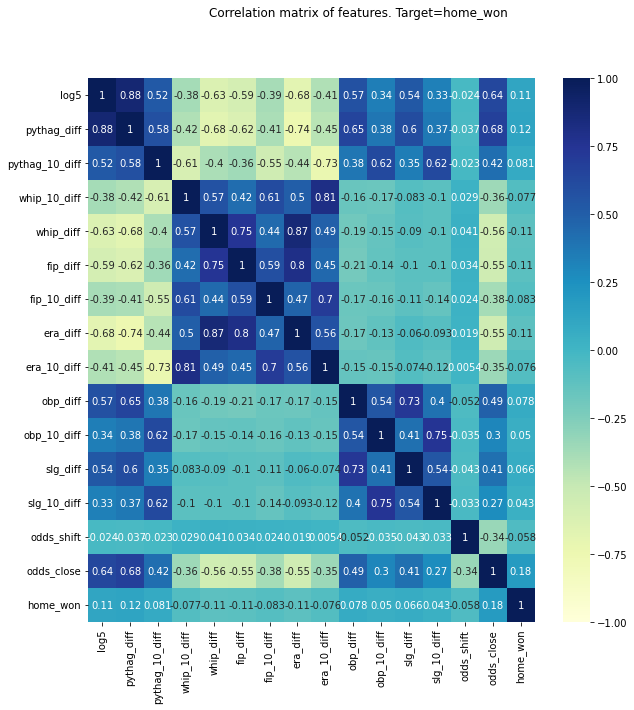

In [1325]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
plt.suptitle('Correlation matrix of features. Target=home_won')
sns.heatmap(games[features_list + ['home_won']].corr(), annot=True, vmin=-1, vmax=1, center=0, cmap='YlGnBu', ax=ax)

Logistic Regression accuracy beats the odds by 0.0051
Boosted Tree accuracy beats the odds by 0.0068


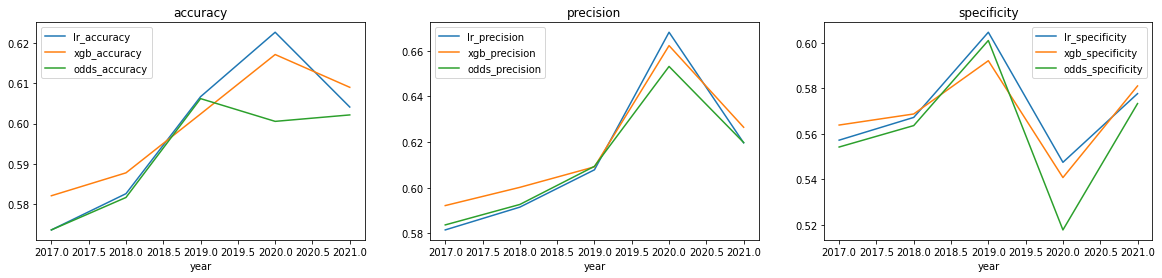

In [1340]:
res = pd.DataFrame(results).set_index('year')
metrics = ['accuracy', 'precision', 'specificity']
fig, ax = plt.subplots(nrows=1, ncols=len(metrics), figsize=(20, 4))
for i, measure in enumerate(metrics):
    measure_res = res[[col for col in res.columns if measure in col]]
    measure_res.plot(ax=ax[i], title=f'{measure}')

print(f"Logistic Regression accuracy beats the odds by {(res['lr_accuracy'].mean() - res['odds_accuracy'].mean()):.4f}")
print(f"Boosted Tree accuracy beats the odds by {(res['xgb_accuracy'].mean() - res['odds_accuracy'].mean()):.4f}")

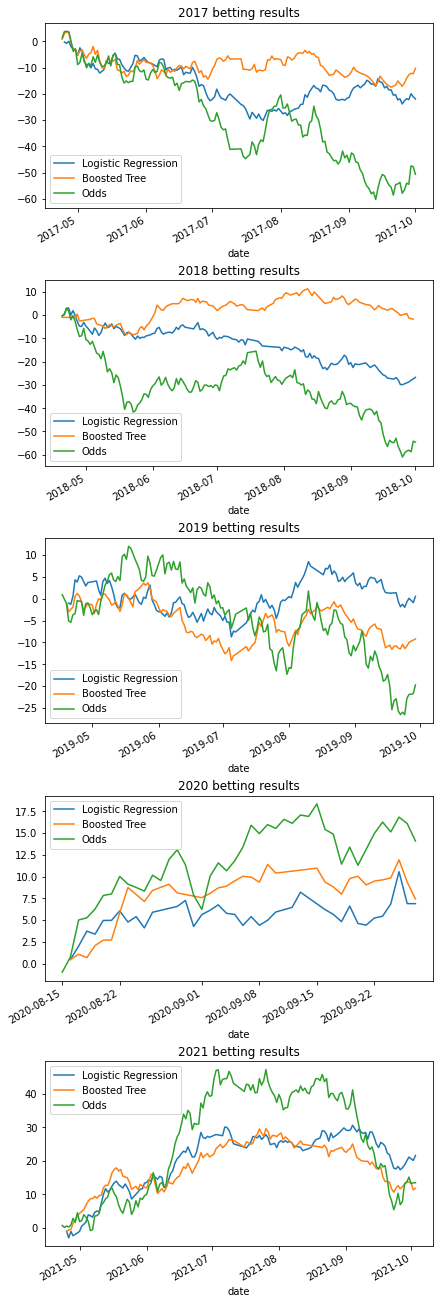

In [1411]:
years = list(range(2017, games['year'].max() + 1))
fig, ax = plt.subplots(nrows=len(years), figsize=(6, 18), constrained_layout=True)

payout = lambda bet: -1 if bet['home_won'] == -1 else (1 / bet['home_odds_close']) * (1 - bet['home_odds_close'])
for i, year in enumerate(years):
    season = result_dfs_by_year[year]

    pred = 'pred_lr'
    bets = season.loc[(season[pred] + .5 > season['home_odds_close']) & (season[pred] > 0),
                      ['date', 'home_won', 'home_odds_close', pred]]
    bets['home_won'] = bets['home_won'].replace(0, -1)
    bets['winnings'] = bets.apply(payout, axis='columns')
    bets.groupby('date').winnings.sum().cumsum().plot(ax=ax[i], label='Logistic Regression')
    
    pred = 'pred_xgb'
    bets = season.loc[(season[pred] + .5 > season['home_odds_close']) & (season[pred] > 0),
                      ['date', 'home_won', 'home_odds_close', pred]]
    bets['home_won'] = bets['home_won'].replace(0, -1)
    bets['winnings'] = bets.apply(payout, axis='columns')
    bets.groupby('date').winnings.sum().cumsum().plot(ax=ax[i], label='Boosted Tree')

    bets = season.loc[(season['home_favorite'] == 1),
                    ['date', 'home_won', 'home_odds_close', pred]]
    bets['home_won'] = bets['home_won'].replace(0, -1)
    bets['winnings'] = bets.apply(payout, axis='columns')
    bets.groupby('date').winnings.sum().cumsum().plot(ax=ax[i], label='Odds')

    ax[i].legend()
    ax[i].title.set_text(f'{year} betting results')